In [1]:
# Uncomment the following lines if you are using Windows!
import findspark
findspark.init()
findspark.find()

import pyspark
from pyspark.sql import SparkSession


spark = SparkSession.builder.master("local[*]").appName('SparkTest').getOrCreate()

In [2]:
from confluent_kafka import Producer
import socket
#Initialize Your Parameters here - Keep the variable values as is for the ones you can't find on the Confluent-Kafka connection 
KAFKA_CONFIG = {
    "bootstrap.servers":"pkc-6ojv2.us-west4.gcp.confluent.cloud:9092",
    "security.protocol":"SASL_SSL",
    "sasl.mechanisms":"PLAIN",
    "sasl.username":"6FIXXDDFR3G4AA45",
    "sasl.password":"vOujNXEdT5SApuistwPeyHdMcaVAHw0oJ3QX6jhsgEOWnt+tUS5mp2hUCNHk3TbM",
    "session.timeout.ms":"45000",
    "group.id":"python-group-1",
    'auto.offset.reset': 'smallest',
    'client.id': socket.gethostname()
}

# Update your topic name
topic_name = "news_topic"
producer = Producer(KAFKA_CONFIG)


In [3]:
from confluent_kafka import Consumer
from pyspark.sql.types import *
import string


# Clean the punctation by making a translation table that maps punctations to empty strings
translator = str.maketrans("", "", string.punctuation)


emp_RDD = spark.sparkContext.emptyRDD()
# Defining the schema of the DataFrame
columns = StructType([StructField('key', StringType(), False),
                      StructField('value', StringType(), False)])

# Creating an empty DataFrame
df = spark.createDataFrame(data=emp_RDD,
                                   schema=columns)
 
# Printing the DataFrame with no data
df.show()

consumer = Consumer(KAFKA_CONFIG)
consumer.subscribe([topic_name])




+---+-----+
|key|value|
+---+-----+
+---+-----+



In [4]:
try:
    i = 0
    while i < 5:
        msg = consumer.poll(timeout=1.0)
        if msg is None:
            i = i + 1
            print("Waiting...")
            continue
        if msg is not None:
            key = msg.key().decode('utf-8').lower().translate(translator)
            cleaned_key = " ".join(key.split())
            value = msg.value().decode('utf-8')
            added_row = [[cleaned_key,value]]
            added_df = spark.createDataFrame(added_row, columns)
            df = df.union(added_df)

except KeyboardInterrupt:
    pass
finally:
    consumer.close()
    df.show()
    #df.head(10)

Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
+--------------------+--------------------+
|                 key|               value|
+--------------------+--------------------+
|nmap 794 released...|https://news.goog...|
|pick out threats ...|https://news.goog...|
|hunting russian i...|https://news.goog...|
|          tcpip csdn|https://news.goog...|
|snort explained u...|https://news.goog...|
|10 best ddos prot...|https://news.goog...|
|malware exploited...|https://news.goog...|
|operating systems...|https://news.goog...|
|linux day18 tcpud...|https://news.goog...|
|what is tracerout...|https://news.goog...|
|akamai we stopped...|https://news.goog...|
|why nessus scanne...|https://news.goog...|
|a quick look at q...|https://news.goog...|
|why shouldnt you ...|https://news.goog...|
|free cybersecurit...|https://news.goog...|
|understanding fir...|https://news.goog...|
|ping of death fre...|https://news.goog...|
|novel andoryubot ...|https://news.goog...|
|any port in a sto...

In [5]:
from pyspark.sql.functions import *
import nltk 
nltk.download('stopwords')

stop_words = nltk.corpus.stopwords.words('english')
streamed_data = df.withColumn('word', explode(split(col('key'), ' '))) \
                .filter(col('word').isin('tcp','udp','icmp')) \
                .groupBy('word') \
                .count() \
                .sort('count', ascending=False)
    
streamed_data.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaicheng\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


+----+-----+
|word|count|
+----+-----+
|icmp|    5|
| tcp|    4|
| udp|    3|
+----+-----+



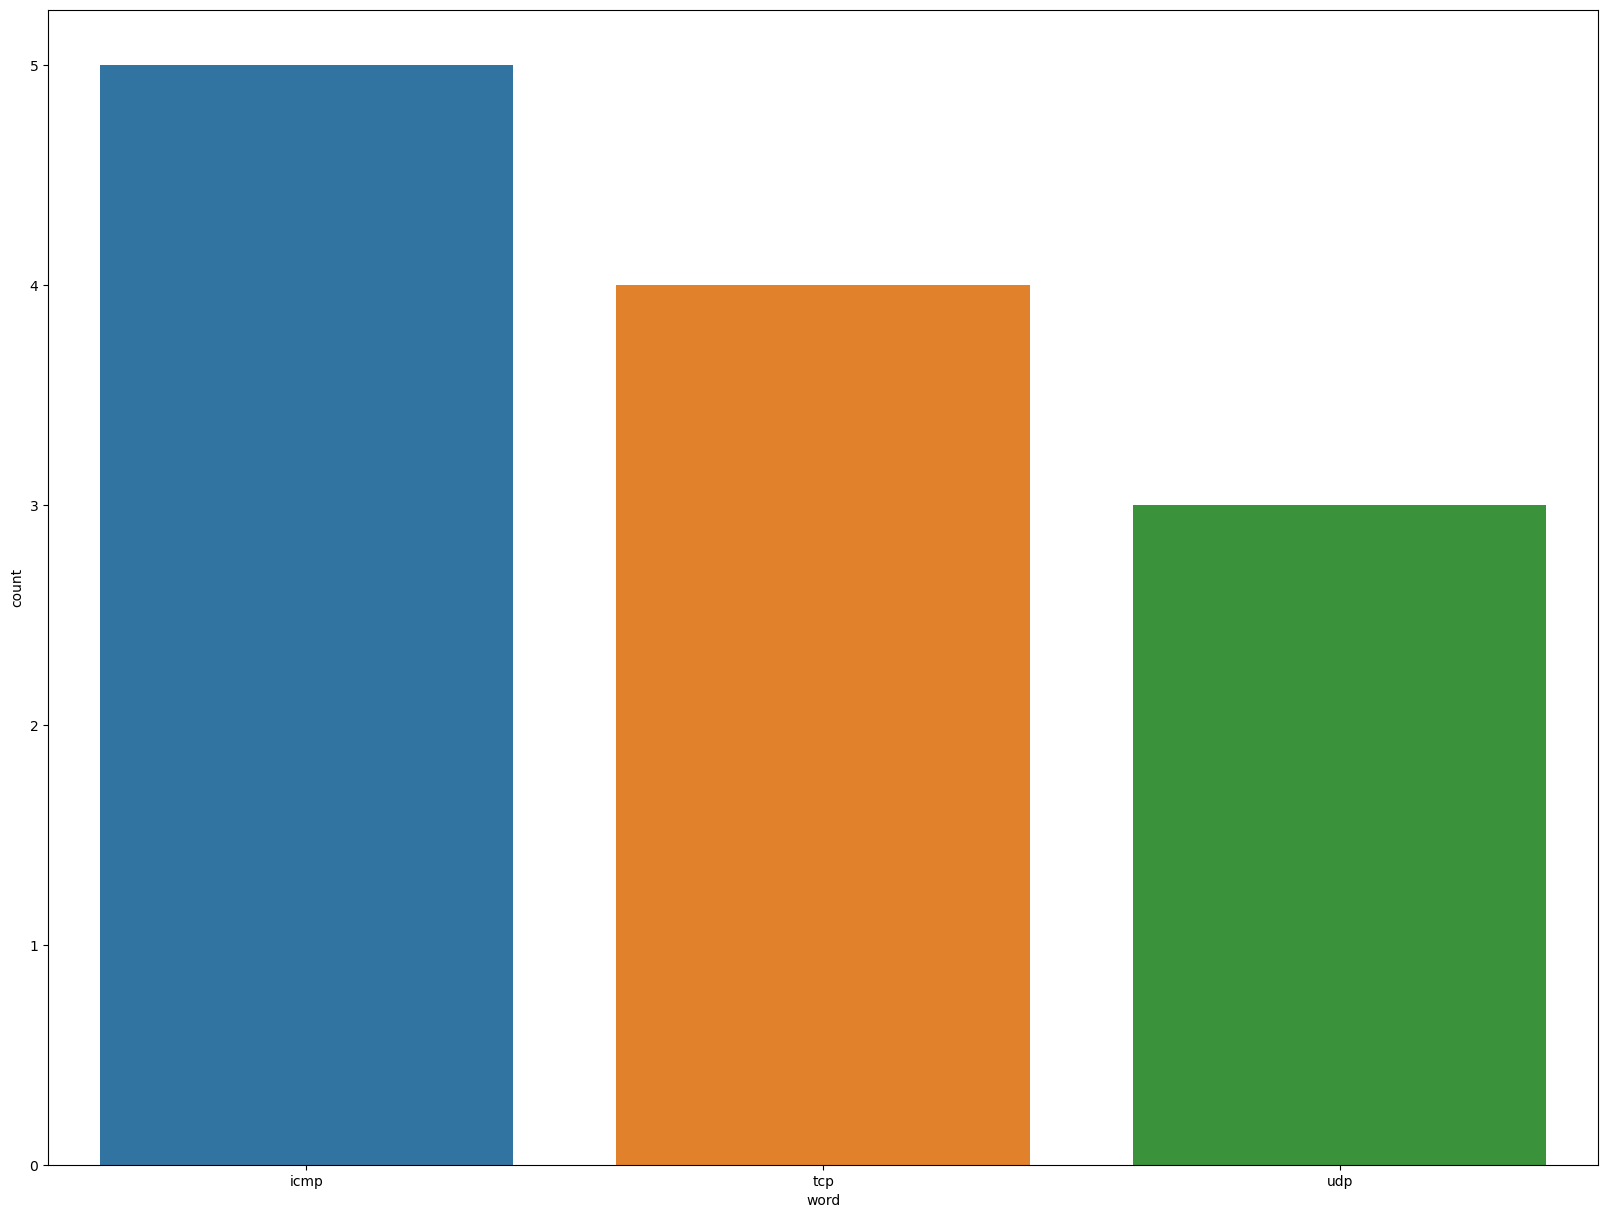

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
top_5_dataframes = streamed_data.orderBy("count",ascending=False).limit(5).toPandas()
plt.figure( figsize = ( 20, 15 ) )
sns.barplot( x="word", y="count", data=top_5_dataframes)
plt.show()

we can infer from the outcome that icmp is the most popular one